# Stroke predictions

### Introduction

Blabla

### Imports and settings

In [1]:
from nptyping import NDArray
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import sys
import time
from typing import Dict, Any
import warnings

np.set_printoptions(threshold=sys.maxsize)
warnings.filterwarnings("ignore")

### Data parsing

The variable *input_path* corresponds to the path of the input CSV file (the healtcare dataset). This file is converted to a pandas dataframe where each row corresponds to a unique patient:

In [2]:
input_path = "stroke_dataset.csv"
df = pd.read_csv(input_path)

Our dataframe contains the following columns:

In [3]:
df.columns= df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


The meanings of the columns are rather self-explanatory. There are 11 features in total, plus the label. The label is represented by the *stroke* column. Note that only the *bmi* column has missing values.

### Data exploration and preprocessing

In the following we will study each column in more detail. Let's start with the *id* column. Since this column will not be relevant to predict strokes, we will simply drop it:

In [4]:
df = df.drop(["id"], axis=1)

The *gender* column shows the following distribution:

In [5]:
df["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

For simplicity, we will only consider two gender options. The *Other* value can be replaced by the majority vote, which is *Female*. Furthermore, we should convert gender into an integer:

In [6]:
df["gender"] = df["gender"].replace(["Other"], "Female")
gender_conversion = {"Male": 0, "Female": 1}
df["gender"] = df["gender"].map(gender_conversion)
df["gender"] = df["gender"].astype(int)
df["gender"].value_counts()

1    2995
0    2115
Name: gender, dtype: int64

Next up is the *age* column:

In [7]:
df["age"].describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

The *hypertension* field takes on the values 0 (no hypertension) and 1 (hypertension). Similarly, *heart_disease* is either 0 (no heart disease) or 1 (heart disease). The distribution of these two variables is as follows:

In [8]:
df[["hypertension", "heart_disease"]].value_counts()

hypertension  heart_disease
0             0                4400
1             0                 434
0             1                 212
1             1                  64
dtype: int64

The column *ever_married* shows whether the patient has ever been married:

In [9]:
df["ever_married"].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

We can easily apply a binary encoding:

In [10]:
married_conversion = {"No": 0, "Yes": 1}
df["ever_married"] = df["ever_married"].map(married_conversion)
df["ever_married"] = df["ever_married"].astype(int)

Next, we have the column *work_type*. There are 5 possible categories:

<AxesSubplot:xlabel='work_type', ylabel='stroke'>

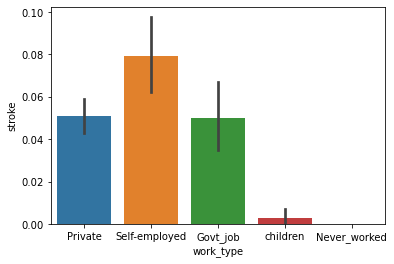

In [11]:
sns.barplot(x='work_type', y='stroke', data=df)

In this plot, the mean values and 95% confidence intervals are shown for the different types of work. We note that *Private* and *Govt_job* have a similar impact on strokes. The same is true for *Children* and *Never_worked*. For this reason, we can create 3 categories instead without loosing much information. Moreover, the fact that a patient is a child is already captured by the *age* field.

In [12]:
df["work_type"] = df["work_type"].replace(["Self-employed"], "self-employed")
df["work_type"] = df["work_type"].replace(["Private", "Govt_job"], "employed")
df["work_type"] = df["work_type"].replace(["children", "Never_worked"], "never_employed")

# Sanity check that children (up to age 12) are never employed:
df.loc[df["age"] < 13, "work_type"] = "never_employed"

df["work_type"].value_counts()

employed          3581
self-employed      818
never_employed     711
Name: work_type, dtype: int64

Since the work type categories are nominal, we can benefit from one-hot encoding:

In [13]:
df_work_ohe = pd.get_dummies(df["work_type"], prefix="work_type", drop_first=True)
df = pd.concat([df, df_work_ohe], axis=1)
df = df.drop(["work_type"], axis=1)

For the *residence_type* field, the distribution is as follows:

In [14]:
df["residence_type"].value_counts()

Urban    2596
Rural    2514
Name: residence_type, dtype: int64

We need to convert this categorical field to a numerical one:

In [15]:
residence_conversion = {"Rural": 0, "Urban": 1}
df["residence_type"] = df["residence_type"].map(residence_conversion)
df["residence_type"] = df["residence_type"].astype(int)

The following column *avg_glucose_level* describes the average glucose level in mg/dL. From the [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451) we learn the following in relation to diabetes:

> A blood sugar level less than 140 mg/dL is normal. A reading of more than 200 mg/dL after two hours indicates diabetes. A reading between 140 and 199 mg/dL indicates prediabetes.

Our glucose level distribution is as follows:

In [16]:
df["avg_glucose_level"].describe()

count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

The next feature column is "smoking_status". The options are as follows:

In [17]:
df["smoking_status"].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

The value *Unknown* means that this information is unavailable for this patient. Since it occurs 1544 times in our dataset, it is best to leave it as a separate category rather than to replace it by guesses. As this variable is somewhat ordinal, we can apply ordinal encoding:

In [18]:
smoking_conversion = {"never smoked": 0, "Unknown": 1, "formerly smoked": 2, "smokes": 3}
df["smoking_status"] = df["smoking_status"].map(smoking_conversion)
df["smoking_status"] = df["smoking_status"].astype(int)

The next column is *bmi*, the body mass index (BMI) in kg/m$^2$. From the [CDC](https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html) we learn the following in relation to obesity:

| BMI | Weight status |
| ---: | :--- |
| < 18.5 | Underweight |
| 18.5 - 24.9 | Normal weight |
| 25.0 - 29.9 | Overweight |
| > 30.0 | Obese |

From earlier we know that there are 201 missing values for this field. We can infer those missing values by feeding the corresponding rows into a linear regression model (obtained by training on the entire remaining dataset): 

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gender                    5110 non-null   int64  
 1   age                       5110 non-null   float64
 2   hypertension              5110 non-null   int64  
 3   heart_disease             5110 non-null   int64  
 4   ever_married              5110 non-null   int64  
 5   residence_type            5110 non-null   int64  
 6   avg_glucose_level         5110 non-null   float64
 7   bmi                       4909 non-null   float64
 8   smoking_status            5110 non-null   int64  
 9   stroke                    5110 non-null   int64  
 10  work_type_never_employed  5110 non-null   uint8  
 11  work_type_self-employed   5110 non-null   uint8  
dtypes: float64(3), int64(7), uint8(2)
memory usage: 409.3 KB


In [20]:
train_data = df.dropna()
X_train = train_data.drop("bmi", axis=1)
y_train = train_data["bmi"]

test_data = df[df["bmi"].isnull()]
X_test = test_data.drop("bmi", axis=1)

model = LinearRegression()
model.fit(X_train, y_train)
y_test = model.predict(X_test)

bmi_slice = df["bmi"].copy()
bmi_slice[np.isnan(bmi_slice)] = y_test
df["bmi"] = bmi_slice

Finally, we have the target column *stroke*. Its values refer to whether the patient has experienced a stroke (1) or not (0).

In [21]:
df["stroke"].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

To conclude the preprocessing, let us verify that there are no longer any missing values and that all fields are numeric of nature:

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gender                    5110 non-null   int64  
 1   age                       5110 non-null   float64
 2   hypertension              5110 non-null   int64  
 3   heart_disease             5110 non-null   int64  
 4   ever_married              5110 non-null   int64  
 5   residence_type            5110 non-null   int64  
 6   avg_glucose_level         5110 non-null   float64
 7   bmi                       5110 non-null   float64
 8   smoking_status            5110 non-null   int64  
 9   stroke                    5110 non-null   int64  
 10  work_type_never_employed  5110 non-null   uint8  
 11  work_type_self-employed   5110 non-null   uint8  
dtypes: float64(3), int64(7), uint8(2)
memory usage: 409.3 KB


### Model building

Now that we have prepared our dataset, we can try to model it with various machine learning algorithms. The one that will show the smallest error, will be picked as our final model.

First, we make a train-test split of the data:

In [23]:
X = df.drop(["stroke"], axis=1)
y = df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Next, we apply standardization (zero mean and unit variance) to *X_train* and *X_test* to ensure that all data 'lives' at the same scale:

In [24]:
scaler = StandardScaler()
feature_sets = [scaler.fit_transform(feature_set) for feature_set in [X_train, X_test]]    
X_train = feature_sets[0]
X_test = feature_sets[1]

Before we start model building, it is good practice to verify the dimensions of the data:

In [25]:
y_train = np.array(y_train)
print("Dimensions of the training set:\n")
print("Features:", X_train.shape, "\nLabels:", y_train.shape)

y_test = np.array(y_test)
print("\nDimensions of the test set:\n")
print("Features:", X_test.shape, "\nLabels:", y_test.shape)

Dimensions of the training set:

Features: (4088, 11) 
Labels: (4088,)

Dimensions of the test set:

Features: (1022, 11) 
Labels: (1022,)


Using the Scikit-learn library, we can quickly try many different machine learning algorithms and select the best one. To this end, we define a function that we can invoke for each algorithm to train and study the corresponding models:

In [26]:
def train_test_model(
        name: str,
        algorithm: Any, 
        X_train: NDArray[float], 
        y_train: NDArray[int], 
        X_test: NDArray[float], 
        y_test: NDArray[int],
) -> Dict[str, float]:
    """Trains and test a model for a given machine learning algorithm.
    
    Args:
        name: The name of the algorithm.
        algorithm: The Scikit-learn algorithm class.
        X_train: The input for training.
        y_train: The labels for training.
        X_test: The input for testing.
        y_test: The labels for testing.
    
    Return:
        The precision, recall, and F1-score pertaining to the obtained model.
    """
    
    classifier = algorithm.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    scores = {"Precision": precision, "Recall": recall, "F1-score": f1}
    
    return scores

We can collect all the algorithms that we want to try out:

In [27]:
algorithms = {
    "Logistic regression": LogisticRegression(),
    "Multilayer perceptron": MLPClassifier(solver="lbfgs"),
}

In the following we train and test models pertaining to all provided algorithms:

In [28]:
model_results = []
for name, algorithm in algorithms.items():
    start_time = time.time()
    scores = train_test_model(
            name, algorithm, X_train, y_train, X_test, y_test
    )
    model_results.append((name, scores["F1-score"]))
    elapsed_time = round(time.time() - start_time, 2)
    print("Algorithm: {}\nDuration: {} seconds\nPrecision: {}, Recall: {}\nF1-score: {}\n".format(name, elapsed_time, scores["Precision"], scores["Recall"], scores["F1-score"]))

Algorithm: Logistic regression
Duration: 0.03 seconds
Precision: 1.0, Recall: 0.019
F1-score: 0.036

Algorithm: Multilayer perceptron
Duration: 1.5 seconds
Precision: 0.118, Recall: 0.111
F1-score: 0.114



From best to worse, our results are as follows: